In [101]:
# !pip install torch
# !pip install pandas
# !pip install scikit-learn


In [102]:
# from google.colab import drive
# drive.mount('/content/drive')

In [103]:
%cd /content/drive/MyDrive/final_exp/code

[Errno 2] No such file or directory: '/content/drive/MyDrive/final_exp/code'
/mnt/DATA/Home/amii.ca/jsheikh/personal_projects/phd_research/phd_research/notebooks


In [104]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import pickle
from scipy.stats import pearsonr
import numpy as np
import copy
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import time

In [105]:
version = 'v3'

In [106]:
geno_training_file = '../processed_data/tr_geno_with_8_m_avg_{}.pkl'.format(version)
pheno_training_file = '../processed_data/tr_pheno_with_8_m_avg_{}.pkl'.format(version)

geno_test_file = '../processed_data/test_geno_with_8_m_avg_{}.pkl'.format(version)
pheno_test_file = '../processed_data/test_pheno_with_8_m_avg_{}.pkl'.format(version)

geno_test_file_unique_env = '../processed_data/test_geno_unique_env_with_8_m_avg_{}.pkl'.format(version)
pheno_test_file_unique_env = '../processed_data/test_pheno_uniqeu_env_with_8_m_avg_{}.pkl'.format(version)

geno_val_file = '../processed_data/val_geno_with_8_m_avg_{}.pkl'.format(version)
pheno_val_file = '../processed_data/val_pheno_with_8_m_avg_{}.pkl'.format(version)

In [107]:
model_path = '../outputs/fc_model_env_beginning_global_features_version_{}.pt'.format(version)
pcc_model_path = '../outputs/fc_model_env_pcc_beginning_global_features_version_{}.pt'.format(version)
target_scaler_path = '../outputs/target_scaler_global_features_{}.pkl'.format(version)
env_scaler_path = '../outputs/env_scaler_global_features_{}.pkl'.format(version)
training_output_path = '../outputs/env_beginning_training_outputs_global_features_' + version + '.pkl'
figure_loss_path = '../figures/loss_env_beginning_global_features_' + version + '.jpeg'
figure_pcc_path = '../figures/pcc_env_beginning_global_features_' + version + '.jpeg'
test_output_all_env_path = '../outputs/predicted_all_env_beginning_global_features_' + version + '.pkl'
test_output_unique_env_path = '../outputs/predicted_unique_env_beginning_global_features_' + version + '.pkl'

In [108]:
def rescale_data(scaler, predicted):
    rescaled = scaler.inverse_transform(predicted.reshape(-1,1))
    
    return rescaled.reshape(-1,)

In [109]:
### Transformer Model

In [110]:
class FCModel(nn.Module):
    def __init__(self, num_env, num_geno, reduce_dim=2666, output_dim=1):
        super(FCModel, self).__init__()

        self.reduce_dim = reduce_dim
        self.num_geno = num_geno
        self.num_env = num_env

        self.linears = nn.ModuleList([nn.Linear(num_env + 1, 54) for i in range(self.num_geno)])
        self.relu1 = nn.ReLU()
        # self.maxpool1 = nn.MaxPool1d(2)
        
        
        self.fc2 = nn.Linear(54, 54)
        self.relu2 = nn.ReLU()
        # self.maxpool2 = nn.MaxPool1d(2)
        
        self.regress = nn.Linear(54, 1)
       
        
    def forward(self, x):
        batch_size = x.shape[0]
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        env = x[:, self.num_geno:  ]
        x = x[:, : self.num_geno]
        
        
        d = torch.zeros([batch_size, self.num_geno, 54]).to(device)
        
        for i, layer in enumerate(self.linears):
          geno = x[:, i]
          geno = torch.unsqueeze(geno, 1)
         
          z = torch.cat((env, geno), dim=1)
       
          out = layer(z)
          d[:, i, :] = out
        x = self.relu1(d)    
       
        x = self.fc2(x)
        x = self.relu2(x)
        
        x= torch.sum(x, dim=1)
    
        x = self.regress(x)
        
        return x

In [111]:
class WheatDataset(Dataset):
    def __init__(self, geno_file, target_file, scaler=None, output_scaler=None):
        self.scaler = scaler
        self.output_scaler=output_scaler
        with open(geno_file, 'rb') as pfile:
            self.data = pickle.load(pfile)

        with open(target_file, 'rb') as pfile:
            self.target = pickle.load(pfile)
        

        ind = self.target <= 10
        self.target = self.target[ind]
        self.data = self.data[ind]
        
        #Remove this line to run with global + local marker set
        # self.data = np.delete(self.data, np.arange(2000, 4052), axis=1)
        
        self.target_original_space = self.target
        self.target_original_space = self.target_original_space.reshape(-1,)

        self.target = self.target.reshape(-1, 1)

        print('number of markers: ', self.data.shape[1])
        print(np.average(self.target))
        print(np.max(self.target))

        if scaler == None:
            self.scaler= MinMaxScaler()
            self.data[:, -81:] = self.scaler.fit_transform(self.data[:, -81:])
        else:
            self.data[:, -81:] = self.scaler.transform(self.data[:, -81:])
            
        if self.output_scaler == None:
            self.output_scaler = MinMaxScaler()
            self.target = self.output_scaler.fit_transform(self.target)
        else:
            self.target = self.output_scaler.transform(self.target)

        self.target = self.target.reshape(-1,)

    def __len__(self):
        return self.data.shape[0]
    
    
    def __getitem__(self, ind):
        return self.data[ind], self.target[ind], self.target_original_space[ind]

In [112]:
def calculate_perf_measure(true, predicted):
    pcc, pval = pearsonr(true, predicted)
    
    return pcc

In [113]:
def pcc_loss(true, predicted):
  x = predicted
  y = true

#   vx = x - torch.mean(x)
#   vy = y - torch.mean(y)

#   cost = torch.sum(vx * vy) / (torch.sqrt(torch.sum(vx ** 2)) * torch.sqrt(torch.sum(vy ** 2)))
  
  x = torch.cat((true, predicted),0)
  cost = torch.corrcoef(x)
  cost = cost[0,1]
  #v2 code added here
  mse_loss = torch.mean((predicted -true)**2)

  total_cost = (1 - cost) + mse_loss

  return total_cost

In [114]:
def train(dataloader, model, criterion, optimizer):
    start_time = time.perf_counter()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    model.train()
    
    tr_running_loss = 0
    predicted = []
    true = []
    count = 0
    for data, target, target_output in dataloader:
        data = data.to(device)
        data = data.float()
        target = target.to(device)
        target= target.float()
        
        optimizer.zero_grad()
        
        outputs = model(data)
        outputs= outputs.view(-1,)
        
        loss = criterion(target, outputs)
        loss.backward()
        
        optimizer.step()
        
        tr_running_loss += loss.item()
        
    
        predicted += outputs.detach().cpu().numpy().tolist()
        true += target.detach().cpu().numpy().tolist()

        count+=1

        # print('batch {} completed'.format(count))

    tr_running_loss = tr_running_loss / count    
    predicted = np.array(predicted)
    true = np.array(true)
    
    pcc = calculate_perf_measure(true, predicted)
    
    end_time = time.perf_counter()
    
    print('Time taken: ', end_time - start_time)
        
    return tr_running_loss, pcc, model

In [115]:
def evaluate(dataloader, model, criterion):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    model.eval()
    
    val_loss = 0
    predicted = []
    true = []
    true_original_space = []
    
    eval_loss = 0
    count = 0
    for data, target, true_scaled in dataloader:
        data = data.to(device)
        data = data.float()
        target = target.to(device)
        target = target.float()
        
        outputs = model(data)
        outputs= outputs.view(-1,)
        
        loss = criterion(target, outputs)
        
        eval_loss += loss.item()
        
        predicted += outputs.detach().cpu().numpy().tolist()
        true += target.detach().cpu().numpy().tolist()
        true_original_space += true_scaled.numpy().tolist()

        count+=1

    eval_loss = eval_loss / count    
    predicted = np.array(predicted)
    true = np.array(true)
    
    pcc = calculate_perf_measure(true, predicted)
    
    return eval_loss, pcc, np.array(true_original_space), predicted

In [116]:
def train_model(tr_dataset, validation_dataset, num_epoch=3000, reduce_dim=256, batch_size=16):
    num_env = 81
    num_geno=tr_dataset.data.shape[1] - num_env
    # num_features = tr_dataset.data.shape[1]
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print('Model is traning on: ', device)
    
    model = FCModel(num_env, num_geno, reduce_dim)
    
    criterion = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    
    tr_loader = DataLoader(dataset=tr_dataset, batch_size=batch_size)
    val_loader = DataLoader(dataset=validation_dataset, batch_size=batch_size)
    
    best_val_loss = np.inf
    best_model = None
    best_pcc = np.NINF
    best_pcc_model = None
    no_improve = 0
    i = 0
    best_epoch = 0
    is_loss_improved = False
    is_pcc_improved = False
    
    tr_losses = []
    val_losses = []
    tr_pccs = []
    val_pccs = []
    while True:
        tr_loss, tr_pcc, model = train(tr_loader, model, criterion, optimizer)
        tr_losses.append(tr_loss)
        tr_pccs.append(tr_pcc)
        
        val_loss, val_pcc, true_original_space, predicted = evaluate(val_loader, model, criterion)
        val_losses.append(val_loss)
        val_pccs.append(val_pcc)
        
        # if val_loss < best_val_loss:
        #     best_val_loss = val_loss
        #     best_model = copy.deepcopy(model)
        #     best_epoch = i
        #     no_improve = 0
        #     is_loss_improved = True
        # else:
        #     is_loss_improved = False
            
        if best_pcc < val_pcc:
            best_val_loss = val_loss
            best_pcc_model = copy.deepcopy(model)
            best_pcc = val_pcc
            best_epoch = i
            no_improve = 0
            is_pcc_improved = True
        else:
            is_pcc_improved = False
            
        if is_pcc_improved == False:
            no_improve += 1
            
        
            
        print("Current epoch: {} Best epoch {}".format(i, best_epoch))
        print("Training Loss: {}, training PCC: {}".format(tr_loss, tr_pcc))
        print("Validation Loss: {}, validation PCC: {}".format(val_loss, val_pcc))
        print()

        i +=1
        
        if i % 15 == 0:
            print('\nSaving model: ')
            # torch.save(best_pcc_model.state_dict(), '../processed_data/fc_model_env_middle_v2.pt')
            # torch.save(best_pcc_model.state_dict(), '../processed_data/fc_model_env_pcc_middle_v2.pt')
        
        if no_improve == 10:
            break
    best_model=best_pcc_model
    
    return best_model, best_pcc_model, tr_losses, tr_pccs, val_losses, val_pccs

In [117]:
def calculate_pcc_by_env():
  test_data = pd.read_csv()
  test_dataset = WheatDataset(geno_test_file, pheno_test_file) 

In [118]:
print('\nSart reading dataset')
tr_dataset = WheatDataset(geno_training_file, pheno_training_file) 
test_dataset = WheatDataset(geno_test_file, pheno_test_file, tr_dataset.scaler, tr_dataset.output_scaler) 
# test_dataset_unique_env = WheatDataset(geno_test_file_unique_env, pheno_test_file_unique_env, tr_dataset.scaler, tr_dataset.output_scaler) 
validation_dataset = WheatDataset(geno_val_file, pheno_val_file, tr_dataset.scaler, tr_dataset.output_scaler) 


Sart reading dataset
number of markers:  4133
4.826152451885187
10.0
number of markers:  4133
4.814854243455251
10.0
number of markers:  4133
4.829793095564701
10.0


In [119]:
tr_dataset.data.shape

(66487, 4133)

In [120]:
print('\nStarting training: ')
best_model, best_pcc_model, tr_losses, tr_pccs, val_losses, val_pccs = train_model(tr_dataset, validation_dataset, reduce_dim=750, batch_size=64)


Starting training: 
Model is traning on:  cuda
Time taken:  3206.9339845529757
Current epoch: 0 Best epoch 0
Training Loss: 4.900229517057631, training PCC: 0.04708672488308351
Validation Loss: 8.557078749954439, validation PCC: 0.09992205155728266



KeyboardInterrupt: 

In [ ]:
model = best_model
torch.save(model.state_dict(), model_path)

In [ ]:
pcc_model = best_pcc_model
torch.save(pcc_model.state_dict(), pcc_model_path)

In [ ]:
with open(target_scaler_path, 'wb') as outfile:
    pickle.dump(tr_dataset.output_scaler, outfile)

In [ ]:
with open(env_scaler_path, 'wb') as outfile:
    pickle.dump(tr_dataset.scaler, outfile)

In [ ]:
df = pd.DataFrame({
    'epochs': list(range(len(tr_losses))) * 2,
    'loss': tr_losses + val_losses,
    'type': ['training'] * len(tr_losses) + ['validation'] * len(val_losses),
    'pcc': np.array(tr_pccs + val_pccs)
})

In [ ]:
df.to_pickle(training_output_path)

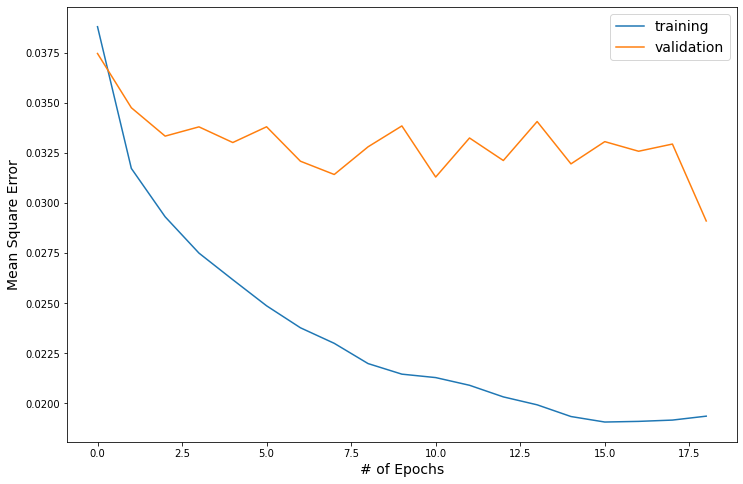

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (12,8))
ax = sns.lineplot(data=df, x="epochs", y="loss", hue="type")
ax.set_xlabel("# of Epochs", fontsize = 14)
ax.set_ylabel("Mean Square Error", fontsize = 14)
ax.legend(fontsize=14)
fig = ax.get_figure()
fig.savefig(figure_loss_path, dpi=256 )

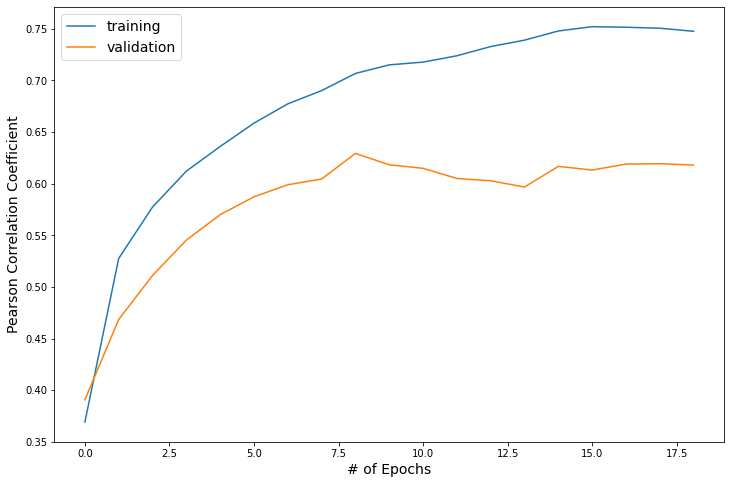

In [ ]:
plt.figure(figsize = (12,8))
ax = sns.lineplot(data=df, x="epochs", y="pcc", hue="type")
fig = ax.get_figure()
ax.set_xlabel("# of Epochs", fontsize = 14)
ax.set_ylabel("Pearson Correlation Coefficient", fontsize = 14)
ax.legend(fontsize=14)
fig.savefig(figure_pcc_path, dpi=256)

In [ ]:
criterion = nn.MSELoss().to('cuda:0')
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [ ]:
test_loss, test_pcc, true_original_space, predicted= evaluate(test_loader, model, criterion)
print('test loss: ', test_loss)
print('test pcc: ', test_pcc)

test loss:  0.032685665936289326
test pcc:  0.626799384694631


In [ ]:
rescaled_predicted = rescale_data(tr_dataset.output_scaler, predicted)
calculate_perf_measure(true_original_space, rescaled_predicted)

0.6267993846284272

In [ ]:
df = pd.DataFrame({
    'True': true_original_space,
    'Predicted': rescaled_predicted
})

In [ ]:
df.to_pickle(test_output_all_env_path)

In [ ]:
# test_loss, test_pcc, true_original_space, predicted = evaluate(test_loader, pcc_model, criterion)
# print('test loss: ', test_loss)
# print('test pcc: ', test_pcc)

In [ ]:
criterion = nn.MSELoss().to('cuda:0')
test_loader = DataLoader(dataset=test_dataset_unique_env, batch_size=64, shuffle=False)

In [ ]:
test_loss, test_pcc, true_original_space, predicted = evaluate(test_loader, model, criterion)
print('test unique env loss: ', test_loss)
print('test unique env pcc: ', test_pcc)

test unique env loss:  0.05289757927035571
test unique env pcc:  0.3855283330103893


In [ ]:
# test_loss, test_pcc, true_original_space, predicted = evaluate(test_loader, pcc_model, criterion)
# print('test unique env loss: ', test_loss)
# print('test unique env pcc: ', test_pcc)

In [ ]:
rescaled_predicted = rescale_data(tr_dataset.output_scaler, predicted)

In [ ]:
calculate_perf_measure(true_original_space, rescaled_predicted)

0.38552833241036266

In [ ]:
df = pd.DataFrame({
    'True': true_original_space,
    'Predicted': rescaled_predicted
})

df.to_pickle(test_output_unique_env_path)